In [1]:
import sys,os,random
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from matplotlib.image import imread

from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Model


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
data_dir_list= os.listdir("/kaggle/input/cifake-real-and-ai-generated-synthetic-images")

In [3]:
# dataset = pd.read_csv

# Plotting first few real Images in Training Set 

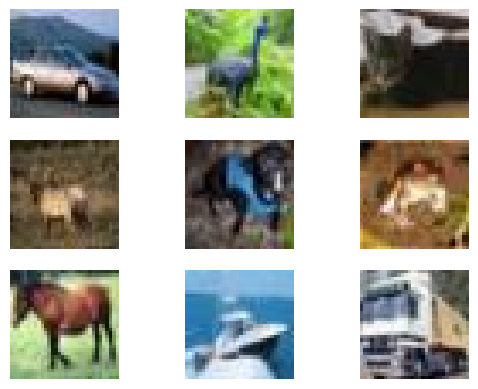

In [4]:
train_real = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/REAL'
# /kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/REAL/0000 (10).jpg
# /kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/REAL/0000 (2).jpg

for i in range(2,11):
    plt.subplot(3,3,i-1)
    filename = train_real+'/0000 '+'('+str(i)+')'+'.jpg'
    # Load image pixels
    image= imread(filename)
    # Plot raw pixel data
    plt.imshow(image)
    plt.axis("off")
plt.show()

# Plotting first few fake images in Training Set 

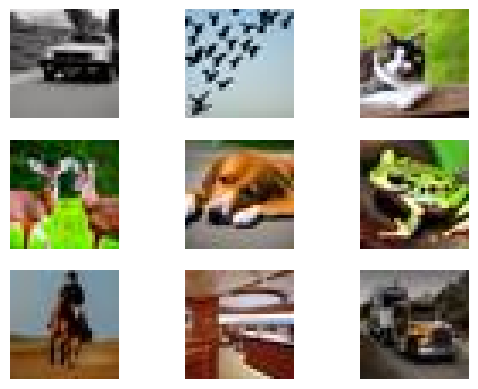

In [5]:
train_fake = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/FAKE'

for i in range(2,11):
    plt.subplot(3,3,i-1)
    filename = train_fake+'/1000 '+'('+str(i)+')'+'.jpg'
    # Load image pixels
    image= imread(filename)
    # Plot raw pixel data
    plt.imshow(image)
    plt.axis("off")
plt.show()

In [6]:
train_root ='/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train'
train_real = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/REAL'
train_fake = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/FAKE'

test_root =  '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test'
test_real =  '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/REAL'
test_fake =  '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/FAKE'

WORKING_DIR = '/kaggle/working'

# Building a Simple CNN Model 

In [7]:
# Model definition
def build_simple_model():
    model = Sequential()
    model.add(Conv2D(32,(3,3),activation="relu",kernel_initializer="he_uniform",padding="same",input_shape=(200,200,3)))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64,(3,3),activation="relu",kernel_initializer="he_uniform",padding="same"))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(128,activation='relu',kernel_initializer="he_uniform"))
    model.add(Dense(1,activation="sigmoid"))
    # Compiling the model
    optimizer=SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    print(model.summary())
    return model


# Defining a tuned VGG Model
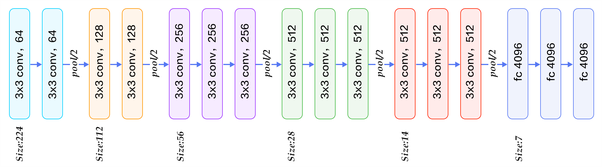

In [8]:
def build_VGG_model():
     # Load VGG16 Model 
    model=VGG16(include_top=False, input_shape=(224,224,3))
     # Mark Loaded layers as non-trainable
    for layers in model.layers:
        layers.trainable=False
    # Add new Classifier Layers
    flat1= Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation="relu", kernel_initializer="he_uniform")(flat1)
    output = Dense(1,activation="sigmoid")(class1)
    model=Model(inputs=model.inputs, outputs=output)
    
     # Compiling the model
    optimizer=SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    print(model.summary())
    return model

# Defining a tuned Inception Model
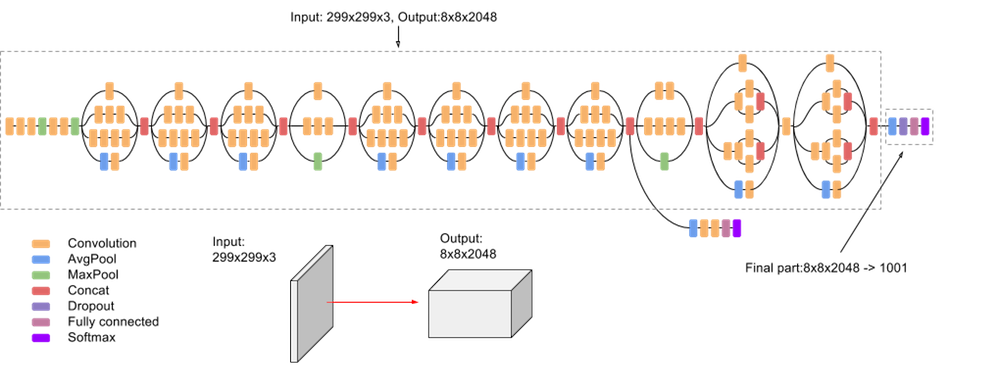

In [9]:
from keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3

def build_Inceptionv3_model():
    inceptionv3 = InceptionV3(include_top=False,input_shape=(224,224,3))
    model= Sequential()
    model.add(inceptionv3)
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    # Since no training parameters in Dropout, Flatten Layers
    model.layers[0].trainable = False

    model.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=1e-4),metrics=['accuracy'])

    print(model.summary())
    return model

# Training Model Function

In [10]:
def train_model(model_type="VGG"):
    # Define & Build the Model
    print("Building Model...")
    if model_type == "Simple":
        model = build_simple_model()
    elif model_type == "VGG":
        model = build_VGG_model()
    elif model_type=="Inception":
        model = build_Inceptionv3_model()
        
    # Create Data Generator
    print("Creating Data Generator...")
    datagen = ImageDataGenerator(rescale=1.0/255.0) # Scaling the pixel values to lie in the range 0-1
    
    # Prepare train & test iterators
    print("Preparing the Training and Validation iterators...")
    BATCH_SIZE = 128
    train_it = datagen.flow_from_directory(train_root, class_mode='binary', batch_size=BATCH_SIZE, target_size=(224, 224))
    test_it = datagen.flow_from_directory(test_root, class_mode='binary', batch_size=BATCH_SIZE, target_size=(224, 224))
    
    # Fit the model
    print("Fitting the Model...")
    hist = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=20)
    
    # Evaluate Model
    print("Evaluating The Model...")
    _, accuracy = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('Accuracy: %.3f%%' % (accuracy * 100.0))
    
    # Plot the loss and accuracy
    print("Plotting Loss & Accuracy...")
    plot_summary(hist)
    
    return model


# Plotting Loss and Accuracy of Model Function

In [11]:
def plot_summary(hist):
    # Plot Loss
    plt.subplot(1,2,1)
    plt.title('Cross Entropy Loss')
    plt.plot(hist.history['loss'],color='b', label= 'Training Loss')
    plt.plot(hist.history['val_loss'],color='g', label= 'Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.title('Classification Accuracy')
    plt.plot(hist.history['accuracy'],color='b', label= 'Training Accuracy')
    plt.plot(hist.history['val_accuracy'],color='g', label= 'Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    # Save Plot to file 
    filename= sys.argv[0].split("/")[-1]
    plt.savefig(filename+'_plot.png')
    plt.close()
    

Building Model...
58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                            

/tmp/ipykernel_22/3401925226.py:27: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, accuracy = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)


Accuracy: 91.740%
Plotting Loss & Accuracy...


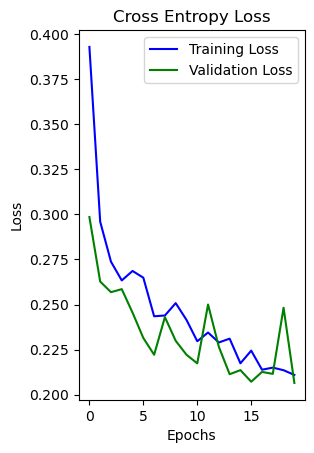

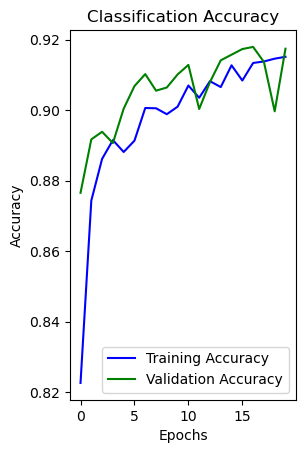

In [12]:
# Builds Trains and Evaluates VGG Model by default
model = train_model()

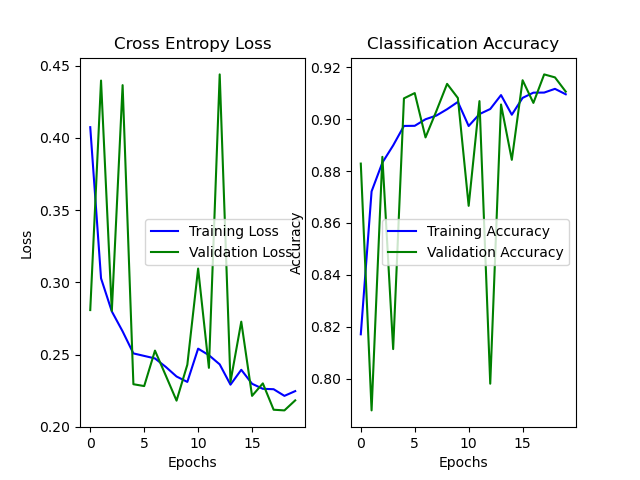

In [13]:
# Saving the model
model.save(WORKING_DIR+'/model.h5')

Building Model...
87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 5, 5, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_1 (Dropout)         (None, 51200)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51201     
                                                                 
Total params: 21,853,985
Trainable params: 51,201
Non-trainable params: 21,802,784
______________________

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


None
Creating Data Generator...
Preparing the Training and Validation iterators...
Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Fitting the Model...
Epoch 1/20


2023-06-28 21:53:47.811311: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


782/782 [==============================] - 322s 403ms/step - loss: 0.5434 - accuracy: 0.7825 - val_loss: 0.3693 - val_accuracy: 0.8470
Epoch 2/20
782/782 [==============================] - 310s 396ms/step - loss: 0.3886 - accuracy: 0.8450 - val_loss: 0.2710 - val_accuracy: 0.8856
Epoch 3/20
782/782 [==============================] - 312s 398ms/step - loss: 0.3470 - accuracy: 0.8617 - val_loss: 0.2619 - val_accuracy: 0.8931
Epoch 4/20
782/782 [==============================] - 321s 411ms/step - loss: 0.3341 - accuracy: 0.8677 - val_loss: 0.2791 - val_accuracy: 0.8835
Epoch 5/20
782/782 [==============================] - 315s 403ms/step - loss: 0.3154 - accuracy: 0.8738 - val_loss: 0.2482 - val_accuracy: 0.8984
Epoch 6/20
782/782 [==============================] - 342s 438ms/step - loss: 0.3080 - accuracy: 0.8777 - val_loss: 0.2515 - val_accuracy: 0.8972
Epoch 7/20
782/782 [==============================] - 312s 399ms/step - loss: 0.3043 - accuracy: 0.8781 - val_loss: 0.2918 - val_accura

/tmp/ipykernel_22/3401925226.py:27: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, accuracy = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)


Accuracy: 90.355%
Plotting Loss & Accuracy...


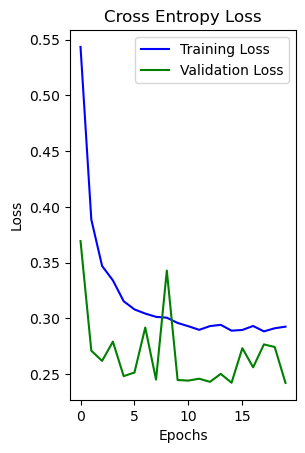

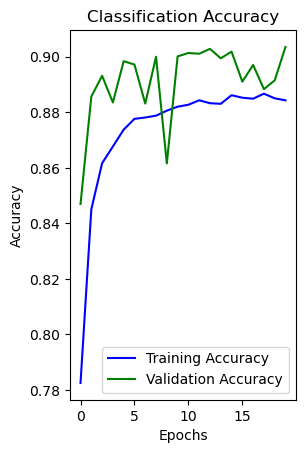

In [14]:
inception_v3_model= train_model("Inception")

In [15]:
inception_v3_model.save(WORKING_DIR+'/inception_v3_model.h5')

# Making Predictions

1/1 [==============================] - 0s 429ms/step
The Image is: AI Generated


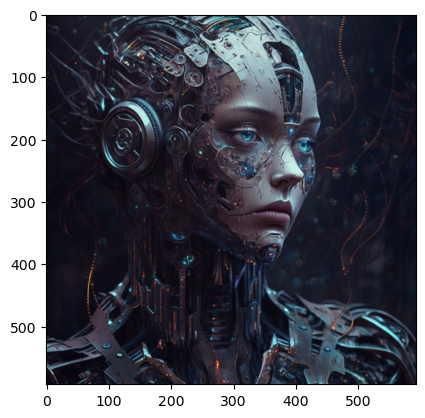

In [16]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

def load_image(filename):
    image = load_img(filename,target_size=(224,224))
    # Convert to Array
    image = img_to_array(image)
    # Reshape image
    image = image.reshape(1,224,224,3)
    # Center Pixel Data
    image = image.astype('float32')
    image = image - [123.68, 116.779, 103.939]
    return image
def run(file):
    img= load_image(file)
    model= load_model('/kaggle/input/data-2/model.h5')
    image= imread(file)
    result= model.predict(img)
    plt.imshow(image)
    if result[0]>=0.5:
        final_result= 'Real'
    else:
        final_result= 'AI Generated'
    print("The Image is: "+final_result)

run('/kaggle/input/data-2/sample.jpg')

    
    